# Imports

In [5]:
from pathlib import Path
import random

import numpy as np
from tifffile import TiffFile
import matplotlib.pyplot as plt
from tqdm import tqdm

from collections import OrderedDict


# Fonctions utiles

In [40]:
class LCD():
    """Class to represent the S2GLC Land Cover Dataset for the challenge,
    with useful metadata and statistics.
    """
    # image size of the images and label masks
    IMG_SIZE = 256
    # the images are RGB+NIR (4 channels)
    N_CHANNELS = 4
    # we have 9 classes + a 'no_data' class for pixels with no labels (absent in the dataset)
    N_CLASSES = 10
    CLASSES = [
        'no_data',
        'clouds',
        'artificial',
        'cultivated',
        'broadleaf',
        'coniferous',
        'herbaceous',
        'natural',
        'snow',
        'water'
    ]
    # classes to ignore because they are not relevant. "no_data" refers to pixels without
    # a proper class, but it is absent in the dataset; "clouds" class is not relevant, it
    # is not a proper land cover type and images and masks do not exactly match in time.
    IGNORED_CLASSES_IDX = [0, 1]

    # The training dataset contains 18491 images and masks
    # The test dataset contains 5043 images and masks
    TRAINSET_SIZE = 18491
    TESTSET_SIZE = 5043

    # for visualization of the masks: classes indices and RGB colors
    CLASSES_COLORPALETTE = {
        0: [0,0,0],
        1: [255,25,236],
        2: [215,25,28],
        3: [211,154,92],
        4: [33,115,55],
        5: [21,75,35],
        6: [118,209,93],
        7: [130,130,130],
        8: [255,255,255],
        9: [43,61,255]
        }
    CLASSES_COLORPALETTE = {c: np.asarray(color) for (c, color) in CLASSES_COLORPALETTE.items()}

    # statistics
    # the pixel class counts in the training set
    TRAIN_CLASS_COUNTS = np.array(
        [0, 20643, 60971025, 404760981, 277012377, 96473046, 333407133, 9775295, 1071, 29404605]
    )
    # the minimum and maximum value of image pixels in the training set
    TRAIN_PIXELS_MIN = 1
    TRAIN_PIXELS_MAX = 24356

In [41]:
def numpy_parse_image(image_path):
    """Load an image and its segmentation mask as numpy arrays and returning a tuple
    Args:
        image_path (bytes): path to image
    Returns:
        (numpy.array[uint16], numpy.array[uint8]): the image and mask arrays
    """
    image_path = Path(bytes.decode(image_path))
    # get mask path from image path:
    # image should be in a images/<image_id>.tif subfolder, while the mask is at masks/<image_id>.tif
    mask_path = image_path.parent.parent/'masks'/image_path.name
    with TiffFile(image_path) as tifi, TiffFile(mask_path) as tifm:
        image = tifi.asarray()
        mask = tifm.asarray()
        # add channel dimension to mask: (256, 256, 1)
        mask = mask[..., None]
    return image, mask

In [42]:
def show_image(image, display_min=50, display_max=400, ax=None):
    """Show an image.
    Args:
        image (numpy.array[uint16]): the image. If the image is 16-bit, apply bytescaling to convert to 8-bit
    """
    if image.dtype == np.uint16:
        iscale = display_max - display_min
        scale = 255 / iscale
        byte_im = (image) * scale
        byte_im = (byte_im.clip(0, 255) + 0.5).astype(np.uint8)
        image = byte_im
    # show image
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    ax.axis("off")
    im = ax.imshow(image)
    return im

def show_mask(mask, classes_colorpalette, classes=None, add_legend=True, ax=None):
    """Show a a semantic segmentation mask.
    Args:
       mask (numpy.array[uint8]): the mask in 8-bit
       classes_colorpalette (dict[int, tuple]): dict mapping class index to an RGB color in [0, 1]
       classes (list[str], optional): list of class labels
       add_legend
    """
    show_mask = np.empty((*mask.shape, 3))
    for c, color in classes_colorpalette.items():
        show_mask[mask == c, :] = color
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    ax.axis("off")
    im = ax.imshow(show_mask)
    if add_legend:
        # show legend mapping pixel colors to class names
        import matplotlib.patches as mpatches
        handles = []
        for c, color in classes_colorpalette.items():
            handles.append(mpatches.Patch(color=color, label=classes[c]))
        ax.legend(handles=handles)
    return im

# Visualisation

In [43]:
DATA_FOLDER_STR = 'D:/my_git/landscape_data/'
DATA_FOLDER = Path(DATA_FOLDER_STR).expanduser()
DATASET_FOLDER = DATA_FOLDER/'dataset'

# get all train images and masks
train_images_paths = sorted(list(DATASET_FOLDER.glob('train/images/*.tif')))
train_masks_paths = sorted(list(DATASET_FOLDER.glob('train/masks/*.tif')))
test_images_paths = sorted(list(DATASET_FOLDER.glob('test/images/*.tif')))

NameError: name 'k' is not defined

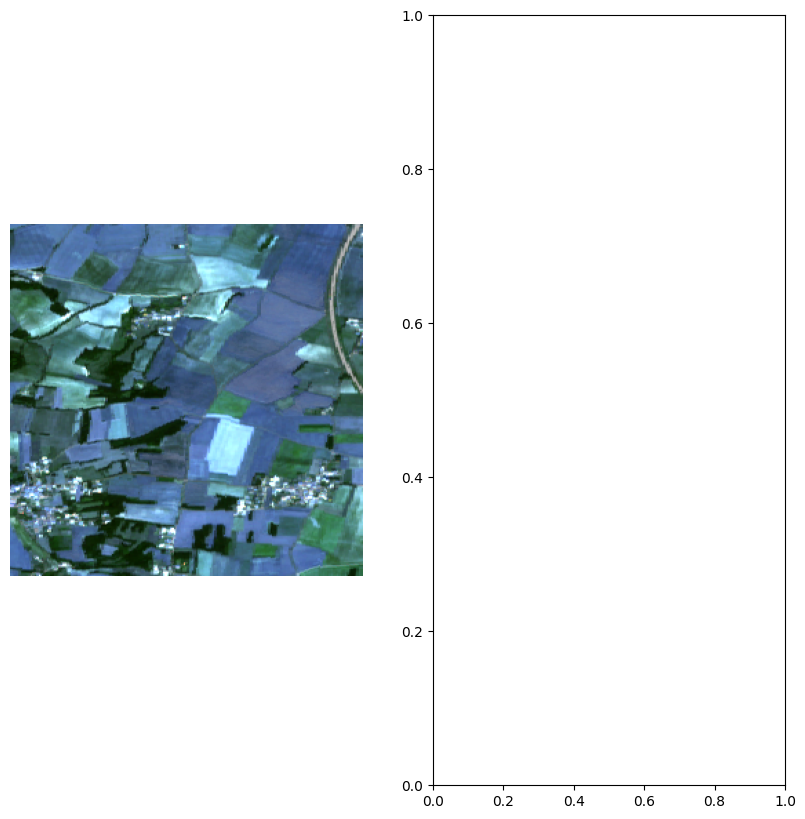

In [44]:
image_path = train_images_paths[0]
mask_path = train_masks_paths[0]

with TiffFile(image_path) as tif:
    arr = tif.asarray()        
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
show_image(arr, display_min=0, display_max=2200, ax=axs[0])

with TiffFile(mask_path) as tif:
    arr = tif.asarray()
classes_colorpalette = {c: color/255. for (c, color) in LCD.CLASSES_COLORPALETTE.items()}
show_mask(arr,
            classes_colorpalette = classes_colorpalette,
            classes=LCD.CLASSES,
            add_legend=(k == 0),
            ax=axs[1]
)
axs[0].set_title(f'Image: {image_path.name}')
axs[1].set_title('Mask')